In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


*   Download your kaggle.json file from Kaggle (under settings/API/Create new token).
*   Create a new folder named 'kaggle' and put your kaggle.json file inside



In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/kaggle'

# Download the dataset

In [3]:
!kaggle datasets download -d gpiosenka/cards-image-datasetclassification

 94% 363M/385M [00:02<00:00, 138MB/s]
100% 385M/385M [00:03<00:00, 131MB/s]


# Imports


In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import pandas as pd
import zipfile

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping

# Unzip the dataset


In [ ]:
file_path = 'cards-image-datasetclassification.zip'

with zipfile.ZipFile(file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/drive/MyDrive/kaggle')

In [5]:
train_dir = "drive/MyDrive/kaggle/train"
train_dataset_dir = pathlib.Path(train_dir)

val_dir = "drive/MyDrive/kaggle/valid"
val_dataset_dir = pathlib.Path(val_dir)

test_dir = "drive/MyDrive/kaggle/test"
test_dataset_dir = pathlib.Path(test_dir)

# Datasets prep

In [15]:
Image_Size = 224
Batch_Size = 32
Epochs = 3

In [11]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_ds = datagen.flow_from_directory(
    train_dataset_dir,
    batch_size=Batch_Size,
    target_size=(Image_Size, Image_Size),
    class_mode='categorical',
    shuffle=True,
)

test_ds = datagen.flow_from_directory(
    test_dataset_dir,
    batch_size=Batch_Size,
    target_size=(Image_Size, Image_Size),
    class_mode='categorical',
    shuffle=True,
)

class_names = list(train_ds.class_indices.keys())

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    val_dataset_dir,
    batch_size=Batch_Size,
    image_size=(Image_Size, Image_Size),
    class_names=class_names,
    label_mode='categorical',
    shuffle=False
)

print(f"Classes: {class_names}")

Found 7624 images belonging to 53 classes.
Found 265 images belonging to 53 classes.
Found 265 files belonging to 53 classes.
Classes: ['ace of clubs', 'ace of diamonds', 'ace of hearts', 'ace of spades', 'eight of clubs', 'eight of diamonds', 'eight of hearts', 'eight of spades', 'five of clubs', 'five of diamonds', 'five of hearts', 'five of spades', 'four of clubs', 'four of diamonds', 'four of hearts', 'four of spades', 'jack of clubs', 'jack of diamonds', 'jack of hearts', 'jack of spades', 'joker', 'king of clubs', 'king of diamonds', 'king of hearts', 'king of spades', 'nine of clubs', 'nine of diamonds', 'nine of hearts', 'nine of spades', 'queen of clubs', 'queen of diamonds', 'queen of hearts', 'queen of spades', 'seven of clubs', 'seven of diamonds', 'seven of hearts', 'seven of spades', 'six of clubs', 'six of diamonds', 'six of hearts', 'six of spades', 'ten of clubs', 'ten of diamonds', 'ten of hearts', 'ten of spades', 'three of clubs', 'three of diamonds', 'three of hea

# Model Creation

In [ ]:
# Based model
base_model = MobileNetV2(weights='imagenet', input_shape=(Image_Size, Image_Size, 3))
base_model.trainable = False

# Custom output layer
x = base_model.output
x = Flatten()(x)
output = Dense(53, activation='softmax')(x)

# Final model
model = Model(inputs=base_model.inputs, outputs=output)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_ds,
    epochs=Epochs,
    validation_data=val_ds,
    callbacks=[EarlyStopping(monitor='val_loss', patience=3)]
)

Epoch 1/3
239/239 [==============================] - 2383s 10s/step - loss: 3.9554 - accuracy: 0.0420 - val_loss: 3.9431 - val_accuracy: 0.0453
Epoch 2/3
239/239 [==============================] - 247s 1s/step - loss: 3.9263 - accuracy: 0.0568 - val_loss: 3.9205 - val_accuracy: 0.0528
Epoch 3/3
239/239 [==============================] - 248s 1s/step - loss: 3.9013 - accuracy: 0.0526 - val_loss: 3.9005 - val_accuracy: 0.0528


# Evaluations

In [ ]:
# Evaluate the model on the testing data
test_loss, test_acc = model.evaluate(val_ds)
print(f"Test Accuracy:, {test_acc:.4f} ")
print(f"Test Loss:, {test_acc:.4f} ")

In [ ]:
# Plot of the accuracy over time
plt.plot(history.history['accuracy'])
plt.show()

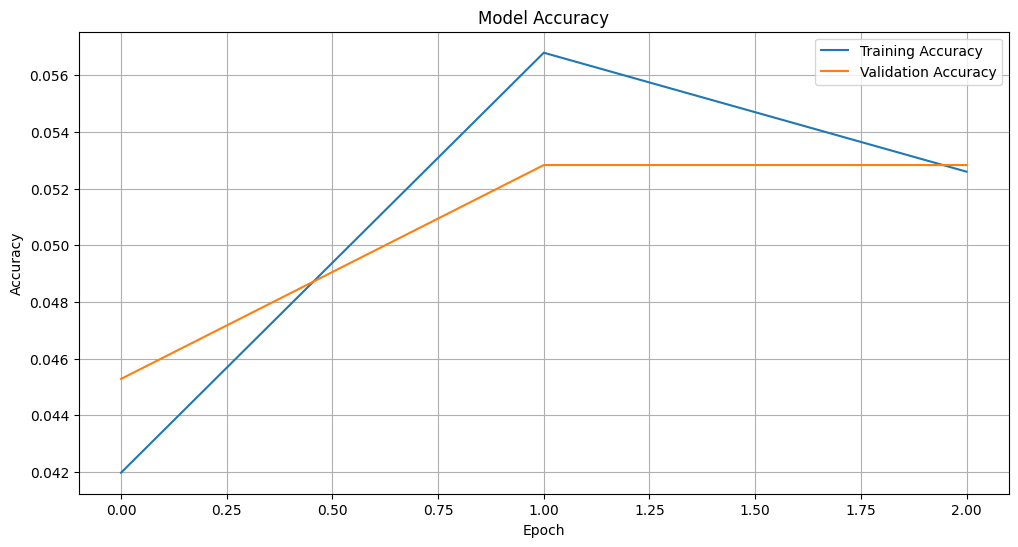

In [19]:
# Plot for training and validation accuracy

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

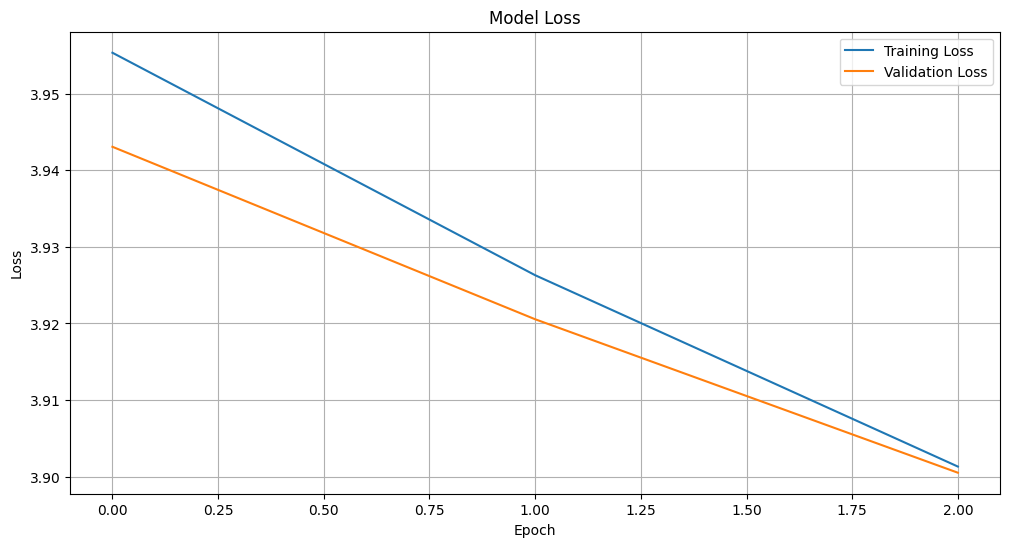

In [20]:
# Plot for training and validation loss

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Predictions

9/9 [==============================] - 9s 921ms/step


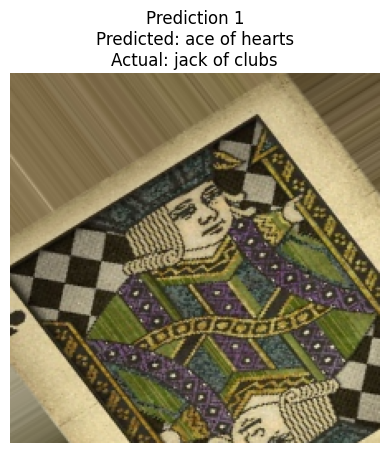

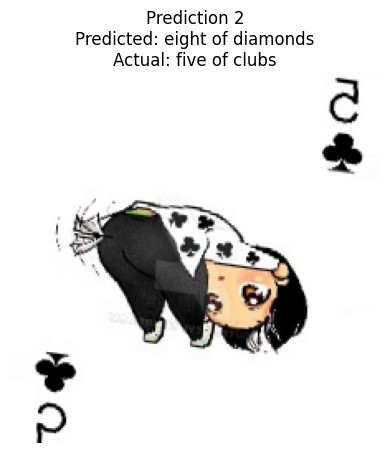

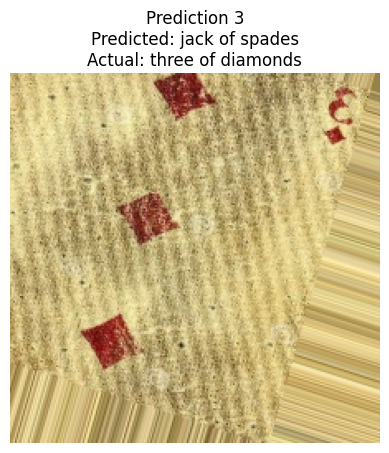

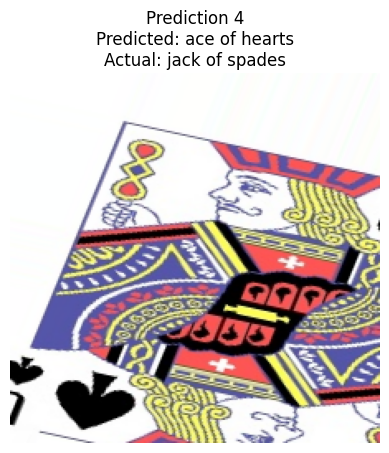

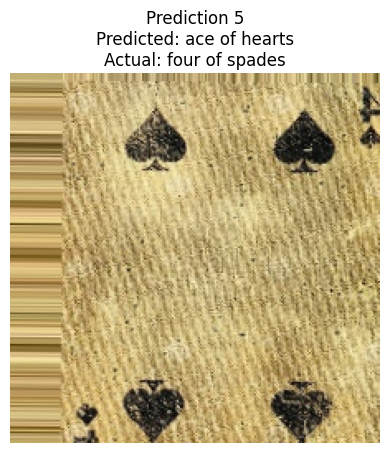

In [42]:
predictions = model.predict(test_ds)

for i in range(5):

    predicted_class_index = np.argmax(predictions[i])

    actual_class_index = np.argmax(test_ds[i][1][0])


    predicted_class = class_names[predicted_class_index]
    actual_class = class_names[actual_class_index]


    image = test_ds[i][0][0]
    plt.imshow(image.astype(np.uint8))
    plt.axis('off')
    plt.title(f"Prediction {i+1}\nPredicted: {predicted_class}\nActual: {actual_class}")
    plt.show()